# Milestone 3

In [69]:
from music21 import pitch, note, stream, duration, corpus, dynamics, instrument, converter, chord
import numpy as np
import random
import copy
# %matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import scipy.io.wavfile as wave
from IPython.display import Audio

## Algorithms

In [70]:
def change_speed(src: stream.Stream, ratio: float,
                 begin: int = 0, end: int = -1) -> None:
    """Changes the speed (duration) of the notes in a given stream.
    (in place)

    Args:
        src (stream.Stream):   The stream on which we want to change the speed
        ratio (float):         The ratio of the change of speed
        begin (int, optional): The beginning measure.
                               Defaults to 0.
        end (int, optional):   The end measure
                               (negative if it's the last measure).
                               Defaults to -1.
    """

    mes = src.getElementsByClass('Measure')

    if end < 0:
        end = len(mes)

    for i in range(begin, end):
        mes[i].augmentOrDiminish(ratio, inPlace=True)

In [71]:
def copy_stream(to_copy: stream.Stream) -> stream.Stream:
    """Copies a stream.

    Args:
      to_copy (stream.Stream): The stream to copy

    Returns:
      stream.Stream: The copy
    """
    new_part = stream.Score()

    for elem in to_copy.elements:
        new_part.insert(elem.offset, copy.deepcopy(elem))

    return new_part

In [72]:
def add_stream(src: stream.Stream, to_add: stream.Stream,
               offset: int = 0) -> None:
    """Adds to a stream another stream (inserts at the beginning).
  
    Args:
      src (stream.Stream):     The stream to which we want to add
      to_add (stream.Stream):  The stream to add
      offset  (optional, int): Where to insert the stream
    """
    if to_add in src.elements:
        to_add = copy_stream(to_add)

    src.insert(offset, to_add)

In [73]:
def remove_stream(src: stream.Stream, to_remove: stream.Stream) -> None:
    """Removes a stream from another stream.
    The stream to remove needs to be an exact reference and not a copy.

    Args:
      src (stream.Stream):       The stream on which we want to remove a stream
      to_remove (stream.Stream): The stream to remove
    """
    src.remove(to_remove, recurse=True)

In [74]:
def add_drone(strm: stream.Score, ptc: pitch.Pitch) -> None:
    """Adds a drone note to a stream (and adds a part for this drone).

    Args:
        strm (stream.Score): The score on which we want to add a drone part
        ptc (pitch.Pitch):   The pitch of the drone
    """
    dur = strm.duration
    n = note.Note()
    n.pitch = ptc
    n.duration = dur

    new_strm = stream.Part()
    new_strm.insert(0, n)
    strm.insert(0, new_strm)

In [75]:
def keep_measures(strm: stream.Part, begin: int, end: int) -> None:
    """Keeps only the indicated measures inside a stream.

    Args:
        strm (stream.Part): The stream
        begin (int):        The index of the first measure to keep
        end (int):          The index of the measure after the last to keep
    """
    mes = strm.getElementsByClass('Measure')

    if end < 0:
        end = len(mes)
 
    for i in range(0, begin):
        for n in mes[i].notes:
            mes[i].remove(n)

    for i in range(end, len(mes)):
        for n in mes[i].notes:
            mes[i].remove(n)

In [76]:
def add_dynamic(strm: stream.Part, dyn: dynamics.Dynamic,
                measure: int = 0, offset: int = 0) -> None:
    """Adds a dynamic in a part.

    Args:
        strm (stream.Part):      The part on which we want to add the dynamic
        dyn (dynamics.Dynamic):  The dynamic to add
        measure (int, optional): The index of the measure.
                                 Defaults to 0.
        offset (int, optional):  The index of the offset inside the measure.
                                 Defaults to 0.
    """
    mes = strm.getElementsByClass('Measure')[measure]
    mes.insert(offset, copy.deepcopy(dyn))

In [77]:
def change_instrument(strm: stream.Part, instr: instrument.Instrument,
                      measure: int = 0, offset: int = 0) -> None:
    """Changes the instrument at a specified location in a part.

    Args:
        strm (stream.Part):            The part on which we want to change the
                                       instrument
        instr (instrument.Instrument): The instrument to add
        measure (int, optional):       The index of the measure where we want to
                                       add the instrument.
                                       Defaults to 0.
        offset (int, optional):        The offset inside of the measure.
                                       Defaults to 0.
    """
    true_offset = strm.getElementsByClass('Measure')[measure].offset + offset

    for instr_in_strm in strm.getElementsByClass('Instrument'):
        if instr_in_strm.offset == true_offset:
            strm.remove(instr_in_strm)
            break

    strm.insert(true_offset, instr)

In [78]:
def move_pitch(note: note.Note, offset: float) -> None:
    """Shifts the pitch by a give-> Nonet
    Pitch goes down if offset < 0 and up if offset > 0

    Args:
        note (note.Note): The note
        offset (float): The offset
    """
    note.pitch.ps += offset


def move_pitches(strm: stream.Part, offset: float,
                 begin: int = 0, end: int = -1) -> None:
    """Moves the pitches of the notes in a stream

    Args:
        strm (stream.Part):    The stream
        offset (float):        The offset
        begin (int, optional): The index of the first measure.
                                   Defaults to 0.
        end (int, optional):   The index of the measure after the last one.
                                   Defaults to -1.
    """
    if end < 0:
        end = len(strm.getElementsByClass('Measure'))

    for mes in strm.getElementsByClass('Measure')[begin:end]:
        for n in mes.notes:
            if isinstance(n, chord.Chord):
                for chord_n in n.notes:
                    move_pitch(chord_n, offset)
            else:
                move_pitch(n, offset)


def random_move_pitches(strm: stream.Part, delta: float,
                        begin: int = 0, end: int = -1) -> None:
    """Randomly move the pitches of the notes in a stream.

    Args:
        strm (stream.Part):    The stream to modify
        delta (float):         By how much we can change the pitches
        begin (int, optional): The starting measure index.
                                   Defaults to 0.
        end (int, optional):   The index of the measure after the last measure.
                                   Defaults to -1.
    """
    if end < 0:
        end = len(strm.getElementsByClass('Measure'))

    for mes in strm.getElementsByClass('Measure')[begin:end]:
        for n in mes.notes:
            if isinstance(n, chord.Chord):
                for chord_n in n.notes:
                    rnd_var = random.uniform(-delta, delta)
                    move_pitch(chord_n, rnd_var)
            else:
                rnd_var = random.uniform(-delta, delta)
                move_pitch(n, rnd_var)


## Structure

### Generation of the structure

In [79]:
# CONSTANTS
AWAKE_PATH = 'Awake.txt'
LIGHT_PATH = 'Light.txt'
DEEP_PATH = 'Deep.txt'
REM_PATH = 'REM.txt'

In [80]:
def read_file_to_list(filename):
    """Reads the file and returns usable data
       only used for (Awake.txt, Light.txt, Deep.txt, REM.txt).
       
       Args:
           file: One of the four mentioned .txt files
        
       Return:
           time_line: List with the timestamps
           probs:     List with the corresponding probabilities
    """
    counter = 0

    with open(filename, 'r') as f:
        data = f.readline()
        time_line = [float(data.split()[0])]
        probs = [float(data.split()[1])]

        line = f.readline()

        while line:
            new_time = float(line.split()[0])
            new_prob = float(line.split()[1])

            if new_time != time_line[counter]:
                # avoid duplicates
                time_line.append(new_time)
                probs.append(new_prob)
                counter += 1

            line = f.readline()

    return time_line, probs


def probability(file, step_prob, size = 25):
    """Changes the data to better match it's uses. Ie regular time interval with
    means.
        
        Args:
            file:            .txt file of which the data should be treated
            step_prob:       an array with the probabilities at time = 0
                             ([[1],[0],[0],[0]])
            size (optional): length of each phase
            
        Return:
            step_prob: probability of the phase after each time interval
    """
    step = size
    start = 0
    time , prob = read_file_to_list(file)
    for x in range(len(time)):
        if time[x] > step:
            step_prob.append(np.mean(prob[start:x]))
            start = x
            step += size
    step_prob.append(np.mean(prob[start:x]))
    return step_prob


def create_probability_seq(step_size = 25):
    """ Creating a sequence of time interval with length step_size and the
    corresponding probabilities of the phases
    
        Args:
            step_size (optional): length of the time interval and with that
                                  length of each phase
        
        Return:
            step_time: sequence of time intervals
            step_prob: the corresponding probabilites of each phase
    """
    step_prob = [[1],[0],[0],[0]]
    step_time = [int(x * step_size) for x in range(int(500/step_size) + 1)]
    step_prob[0] = probability(AWAKE_PATH, step_prob[0], step_size)
    step_prob[1] = probability(REM_PATH, step_prob[1], step_size)    
    step_prob[2] = probability(LIGHT_PATH, step_prob[2], step_size)
    step_prob[3] = probability(DEEP_PATH, step_prob[3], step_size)
    return step_time, step_prob


def create_phase_seq(phase_length = 25):
    """ Creates the sequence of phases during the sleep
        
        Args:
            phase_length (optional): Length of each phase in time-units
        
        Return:
            time_axis: x-axis of the plot in time-units
            y_axsis:   y-axsis of the plot i.e. the phases
                      (3=awake, 2=rem, 1=light, 0=deep)
    """
    time_axis , step_prob = create_probability_seq(phase_length)
    
    probs = []
    
    for i in range(len(step_prob[0])):
        probs.append([step_prob[0][i],step_prob[1][i],step_prob[2][i],step_prob[3][i]])

    y_axis = [random.choices([3,2,1,0],probs[i]) for i in range(len(probs))]
    return time_axis, y_axis

## Sleep phases

### Awake

In [81]:
def algo_awake(ogstrm: stream.Score, begin: int = 0, end: int = -1) -> stream.Score:
    if end is None or end < 0:
        end = len(ogstrm.parts[0].getElementsByClass('Measure'))

    ogstrm = copy_stream(ogstrm)

    for i in range(len(ogstrm.parts)):
        new_part = ogstrm.parts[i]
        keep_measures(new_part, begin + i, end)

    return ogstrm

### Light sleep

In [82]:
def algo_light(strm: stream.Score, begin: int = 0, end: int = -1) -> stream.Score:
    cpy = copy_stream(strm)

    for p in cpy.parts:
        add_dynamic(p, dynamics.Dynamic('p'), measure=begin)
        move_pitches(p, -5, begin, end)
        keep_measures(p, begin, end)

    return cpy

### REM

In [83]:
def algo_rem(strm: stream.Score, begin: int = 0, end: int = -1) -> stream.Score:
    cpy = copy_stream(strm)

    for p in cpy.parts:
        keep_measures(p, begin, end)
        change_speed(p, 0.5, begin, end)
        add_dynamic(p, dynamics.Dynamic('ff'), begin)

    return cpy

### Deep sleep

In [84]:
def algo_deep(strm: stream.Score, begin: int = 0, end: int = -1) -> stream.Score:
    cpy = copy_stream(strm)

    for p in cpy.parts[1:]:
        # remove all but the melody
        for mes in p.getElementsByClass('Measure'):
            for n in mes.notes:
                mes.remove(n)

    p = cpy.parts[0]    
    change_speed(p, 2, begin, end)
    move_pitches(p, -10, begin, end)
    random_move_pitches(p, 0.5, begin, end)

    keep_measures(p, begin, end)

    return cpy

## Putting the piece together

### Algorithms

In [85]:
AWAKE = 'Awake'
REM = 'REM'
LIGHT = 'Light'
DEEP = 'Deep'

phases = [AWAKE, REM, LIGHT, DEEP]


def show_plot(step_time, endit, save=False) -> None:
    phases = ['Awake','REM','Light','Deep']
    plt.plot(step_time,endit)
    plt.yticks([3,2,1,0], phases)

    if save:
        plt.savefig('plot/plot', format='pdf')

    plt.show()


def generate_phases(score: stream.Score, save_plot=False) -> dict:
    # create phases list
    step_time, endit = create_phase_seq(50)

    phases_list = list(map(lambda i: phases[len(phases) - i[0] - 1], endit))
    phases_list.append(AWAKE)


    # create dictionary of measure indices to sleep phases
    total_measures = len(score.parts[0].getElementsByClass('Measure'))

    phases_mes = {}

    for i in range(len(phases_list)):
        mes_nbr = int(i * (total_measures / len(phases_list)))
        phases_mes[mes_nbr] = phases_list[i]

    print("Phases : ", phases_mes)

    show_plot(step_time, endit, save=save_plot)

    return phases_mes


def merge_parts(strm1, strm2):
    meslist1 = strm1.getElementsByClass('Measure')
    meslist2 = strm2.getElementsByClass('Measure')

    for i in range(len(meslist1)):
        mes1 = meslist1[i]
        mes2 = meslist2[i]
        
        for n in mes2.notes:
            mes1.insert(n)


def apply_sleep_phase(base_piece, begin, end, phase):
    func = None

    if phase == AWAKE:
        func = algo_awake
    elif phase == REM:
        func = algo_rem
    elif phase == LIGHT:
        func = algo_light
    elif phase == DEEP:
        func = algo_deep
        
    return func(base_piece, begin, end)


def create_base_score():
    score = stream.Score()
    lh = stream.Score()
    rh = stream.Score()
    score.insert(0, lh)
    score.insert(0, rh)
    return score, lh, rh

Begin computing score
Phases :  {0: 'Awake', 8: 'Awake', 17: 'Light', 26: 'Light', 34: 'Awake', 43: 'Deep', 52: 'Deep', 60: 'Light', 69: 'REM', 78: 'Awake', 86: 'Awake', 95: 'Awake'}


/Users/loicbacci/opt/anaconda3/envs/algo/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/loicbacci/opt/anaconda3/envs/algo/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


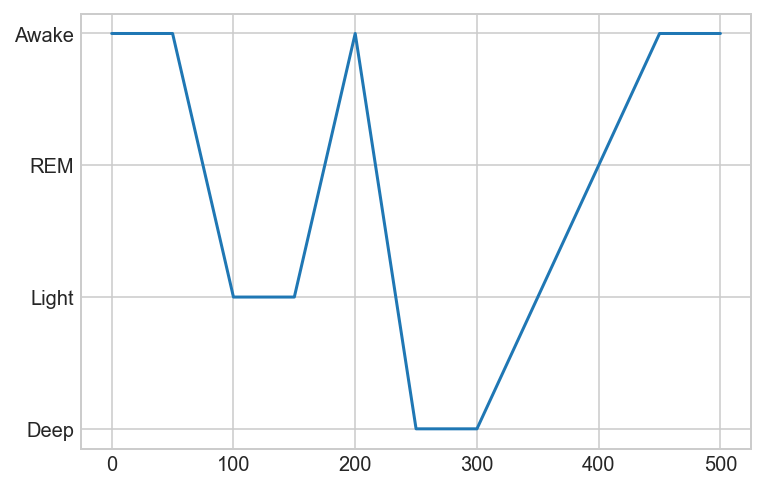

Finished generating parts
Finished generating final score


In [86]:
print("Begin computing score")

base = converter.parse('fur_elise.mxl')

phases_mes = generate_phases(base, save_plot=True)
mes_list = list(phases_mes.keys())
total_measures = len(score.parts[0].getElementsByClass('Measure'))

# Generate the separate parts (material used to create the final audio)
a_score = algo_awake(base)
l_score = algo_light(base)
r_score = algo_rem(base)
d_score = algo_deep(base)

a_score.write('midi', fp='midi/awake.mid')
l_score.write('midi', fp='midi/light.mid')
r_score.write('midi', fp='midi/rem.mid')
d_score.write('midi', fp='midi/deep.mid')

print("Finished generating parts")

# Create a score with separate left and right hands
final_score = stream.Score()
lh = stream.Score()
rh = stream.Score()
final_score.insert(0, lh)
final_score.insert(0, rh)

for i in range(len(mes_list)):
    mes_begin = mes_list[i]
    mes_end = 0
    
    if i == len(mes_list) - 1:
        mes_end = total_measures
    else:
        mes_end = mes_list[i+1]
    
    new_piece = apply_sleep_phase(base, mes_begin, mes_end, phases_mes[mes_begin])
    lh.insert(0, new_piece.parts[0])
    rh.insert(0, new_piece.parts[1])

# Flatten the parts so the final score only contains the left and right hand parts
final_score.replace(lh, lh.flattenParts())
final_score.replace(rh, rh.flattenParts())

final_score.write('midi', fp='midi/piece.mid')
print("Finished generating final score")

## Final piece visualization

Hardcoded the sleep phases used in the final piece

[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500] [[3], [1], [1], [0], [0], [1], [2], [1], [2], [1], [3]]


/Users/loicbacci/opt/anaconda3/envs/algo/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/loicbacci/opt/anaconda3/envs/algo/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


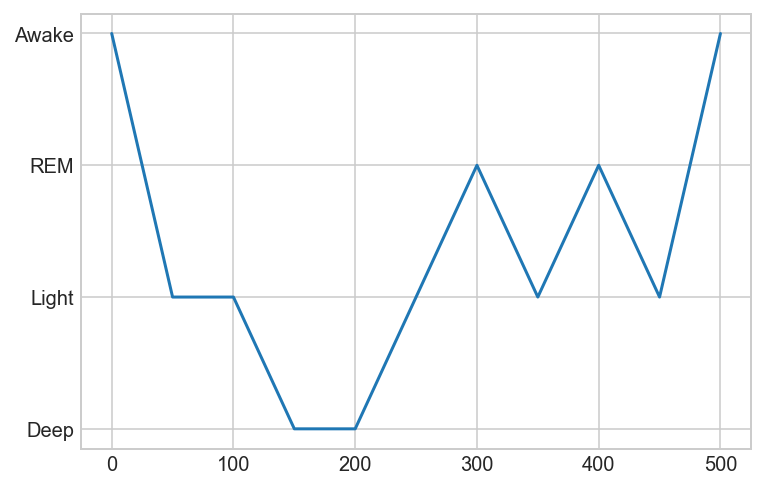

In [87]:
phases = ['Awake','REM','Light','Deep']
step_time, endit = create_phase_seq(50) #The integer can be set as 10,20,25,50,100,250
endit = [[3], [1], [1], [0], [0], [1], [2], [1], [2], [1], [3]]
print(step_time, endit)
plt.plot(step_time,endit)
plt.yticks([3,2,1,0], phases)
plt.savefig('plot/plot', format='pdf')
plt.show()